In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate max date the date 1 year ago from the last data point in the database (**use session.query)
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest)

#Last 12 month (2016/08/23 - 2017/08/23)

('2017-08-23',)


In [11]:
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
prec = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>='2016-08-23').order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prec)
df.set_index('date', inplace=True)
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


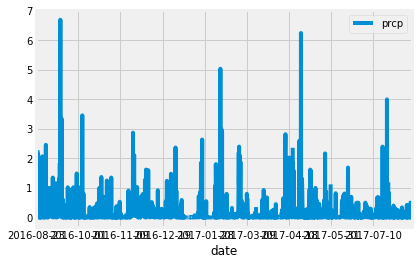

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [39]:
# Design a query to show how many stations are available in this dataset?
Station_count = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {Station_count} stations available in the dataset")

There are 9 stations available in the dataset


In [40]:
# What are the most active stations? (i.e. what stations have the most rows)? group_by
# List the stations and the counts in descending order.
ActiveSt = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
ActiveSt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
MActiveSt = ActiveSt[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.station == MActiveSt).all()

[(54.0, 71.66378066378067, 85.0)]

In [42]:
# Choose the station with the highest number of temperature observations.
temp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == MActiveSt).filter(Measurement.date >= '2016-08-23').all()
temp_df = pd.DataFrame(temp)
temp_df.set_index('station', inplace=True)
temp_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

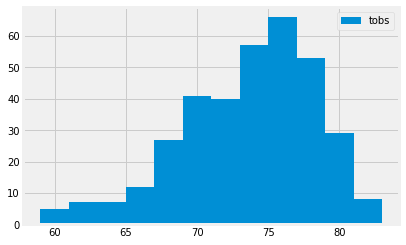

In [43]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp_df['tobs'], bins=12)
plt.legend(["tobs"])
plt.show

![precipitation](Images/station-histogram.png)

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-05-15'
end_date = '2017-05-21'
example = calc_temps(start_date, end_date)
example

[(68.0, 74.48717948717949, 80.0)]

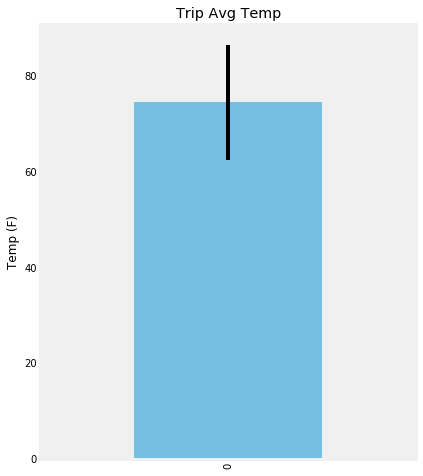

In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_df = pd.DataFrame(example, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = my_df['Avg Temp']
min_max_temp = my_df.iloc[0]['Max Temp'] - my_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.grid()
plt.show()

In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
precip = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).all()
precip_df = pd.DataFrame(precip, columns = ['Station', 'Precipitation Totals'])
precip_df

,Station,Precipitation Totals
0,USC00513117,0.24
1,USC00514830,0.23
2,USC00516128,0.96
3,USC00519281,0.36
4,USC00519397,0.07
5,USC00519523,0.52


In [49]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))\
.filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
.group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.96),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.52),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.36000000000000004),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.23000000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.07)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
